# Task 2B - Find Likelihood to be Bad Actor

## Library and Pre-process

In [2]:
# Basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-Learn library
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc,\
                            confusion_matrix, roc_curve

# Resampling library
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [3]:
# Resampling library
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [4]:
# Read main dataset
df = pd.read_csv('UofT_nodes.csv')
df_bad_list = pd.read_csv('badactor_foundin_kyc_bt_match.csv')

In [5]:
# Change all to categorical
df['COUNTRY_RISK_INCOME'] = df['COUNTRY_RISK_INCOME'].astype('category').cat.codes
df['COUNTRY_RISK_RESIDENCY'] = df['COUNTRY_RISK_RESIDENCY'].astype('category').cat.codes
df['GENDER'] = df['GENDER'].astype('category').cat.codes

df['RISK'] = df['RISK'].replace(['low'], 0)
df['RISK'] = df['RISK'].replace(['medium'], 1)
df['RISK'] = df['RISK'].replace(['high'], 2)

In [6]:
# Convert Key(Customer ID) to int for join
df.CUSTOMER_ID = df.CUSTOMER_ID.astype(float).astype(int)
df_bad_list.CUSTOMER_ID = df_bad_list.CUSTOMER_ID.astype(float).astype(int)

# Change all date to date format
df.BIRTH_DT = pd.to_datetime(df.BIRTH_DT)
df.CUST_ADD_DT = pd.to_datetime(df.CUST_ADD_DT)

# Fill NaN with value different from the other
# noinspection PyTypeChecker
df.CUST_ADD_DT.fillna(pd.Timestamp('2023-01-01'), inplace=True)
df.OCPTN_NM.fillna(-1, inplace=True)

# Convert all dates to Unix timestamps for modeling (values are not intuitive)
# df['BIRTH_TS'] = df['BIRTH_DT'].apply(lambda x: x.timestamp())
# df['CUST_ADD_TS'] = df['CUST_ADD_DT'].apply(lambda x: x.timestamp())

# Generate new features for feature selection
df['BIRTH_DU'] = pd.Timestamp('2022-12-31') - df['BIRTH_DT']
df['CUST_ADD_DU'] = pd.Timestamp('2022-12-31') - df['CUST_ADD_DT']
df['BIRTH_DU'] = df['BIRTH_DU'].astype('int64') // (10**9 * 86400 * 365)
df['CUST_ADD_DU'] = df['CUST_ADD_DU'].astype('int64') // (10**9 * 86400 * 365)
df['CASH_AVE_IN'] = df['CASH_SUM_IN']/df['CASH_CNT_IN']
df['CASH_AVE_OUT'] = df['CASH_SUM_OUT']/df['CASH_CNT_OUT']
df['WIRES_AVE_IN'] = df['WIRES_SUM_IN']/df['WIRES_CNT_IN']
df['WIRES_AVE_OUT'] = df['WIRES_SUM_OUT']/df['WIRES_CNT_OUT']

# See data heath of main dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 26 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   BIRTH_DT                1000000 non-null  datetime64[ns]
 1   CUST_ADD_DT             1000000 non-null  datetime64[ns]
 2   OCPTN_NM                1000000 non-null  float64       
 3   RES_CNTRY_CA            1000000 non-null  int64         
 4   CNTRY_OF_INCOME_CA      1000000 non-null  int64         
 5   PEP_FL                  1000000 non-null  float64       
 6   CASH_SUM_IN             1000000 non-null  float64       
 7   CASH_CNT_IN             1000000 non-null  float64       
 8   CASH_SUM_OUT            1000000 non-null  float64       
 9   CASH_CNT_OUT            1000000 non-null  float64       
 10  WIRES_SUM_IN            1000000 non-null  float64       
 11  WIRES_CNT_IN            1000000 non-null  float64       
 12  WIRES_SUM_OUT  

In [7]:
# See data heath of bad actors dataset
df_bad_list.CUSTOMER_ID = df_bad_list.CUSTOMER_ID.astype(float).astype(int)
df_bad_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              50 non-null     int64  
 1   BIRTH_DT                50 non-null     object 
 2   CUST_ADD_DT             50 non-null     object 
 3   OCPTN_NM                50 non-null     float64
 4   RES_CNTRY_CA            50 non-null     int64  
 5   CNTRY_OF_INCOME_CA      50 non-null     int64  
 6   PEP_FL                  50 non-null     float64
 7   CASH_SUM_IN             50 non-null     float64
 8   CASH_CNT_IN             50 non-null     float64
 9   CASH_SUM_OUT            50 non-null     float64
 10  CASH_CNT_OUT            50 non-null     float64
 11  WIRES_SUM_IN            50 non-null     float64
 12  WIRES_CNT_IN            50 non-null     float64
 13  WIRES_SUM_OUT           50 non-null     float64
 14  WIRES_CNT_OUT           50 non-null     floa

In [8]:
# Create bad actor label
df_bad_list['BAD_STATUS'] = [True]*df_bad_list.shape[0] # Create True labels for real bad actors 
df = df.merge(df_bad_list[['BAD_STATUS', 'CUSTOMER_ID']], on='CUSTOMER_ID', how='left') # Join
df['BAD_STATUS'].fillna(False, inplace=True) # Fill the rest with False labels

# Check whether merged correctly
set(df_bad_list.CUSTOMER_ID) == set(df[df['BAD_STATUS']].CUSTOMER_ID)

True

In [9]:
# Show data distribution on BAD_STATUS
bad_count = df.groupby('BAD_STATUS').count()['NAME'].reset_index()
bad_count.rename(columns={'BAD_STATUS':'Bad Actor', 'NAME':'Count'}, inplace=True)
bad_count['Percentage'] = bad_count['Count']/sum(bad_count['Count'])
bad_count

,Bad Actor,Count,Percentage
0,False,999290,0.99995
1,True,50,0.00005


## Variable Selection

In [10]:
# Set variable will be used for training, exclude ground truth features like 'Name'
column_feature = df.columns[2:17].to_list() + df.columns[20:-1].to_list()

# Show all features
column_feature

['OCPTN_NM',
 'RES_CNTRY_CA',
 'CNTRY_OF_INCOME_CA',
 'PEP_FL',
 'CASH_SUM_IN',
 'CASH_CNT_IN',
 'CASH_SUM_OUT',
 'CASH_CNT_OUT',
 'WIRES_SUM_IN',
 'WIRES_CNT_IN',
 'WIRES_SUM_OUT',
 'WIRES_CNT_OUT',
 'COUNTRY_RISK_INCOME',
 'COUNTRY_RISK_RESIDENCY',
 'RISK',
 'BIRTH_DU',
 'CUST_ADD_DU',
 'CASH_AVE_IN',
 'CASH_AVE_OUT',
 'WIRES_AVE_IN',
 'WIRES_AVE_OUT']

In [11]:
# Split
X = df[column_feature]
y = df['BAD_STATUS']

# Feature selection with correlation calculation
corr = X.corrwith(y)

# Get the selected feature names
k = 15
indices = corr.abs().sort_values(ascending=False)[:15].index
selected_features = X[indices].columns.tolist()
X = X[selected_features]

# Show features
selected_features

['COUNTRY_RISK_INCOME',
 'CNTRY_OF_INCOME_CA',
 'RISK',
 'RES_CNTRY_CA',
 'CASH_SUM_IN',
 'COUNTRY_RISK_RESIDENCY',
 'CASH_CNT_IN',
 'WIRES_CNT_OUT',
 'CASH_CNT_OUT',
 'CASH_SUM_OUT',
 'BIRTH_DU',
 'WIRES_SUM_OUT',
 'OCPTN_NM',
 'WIRES_SUM_IN',
 'PEP_FL']

## Logistic Regression Modelling

In [12]:
# Training the logistic regression model with resampling methods
def train_lr(X_train_norm:pd.DataFrame,
             y_train:pd.DataFrame,
             lr_model:LogisticRegression,
             iter:int = 10,
             rand_seed:int = 40,
             resample:str = None):
    
    # Check resample method input sanity
    if resample:
        assert resample=='ROS' or resample=='SMOTE',\
            f"resample can only be 'ROS'or 'SMOTE'"
    
    # Initialize an empty list to store the accuracy scores
    acc_scores = []
    prec_scores = []
    rec_scores = []

    # Apply different resampling method to enlarge the bad actor sample size
    if resample == 'ROS': # Random Oversampling
        ros = RandomOverSampler(random_state=rand_seed)
        X_train_norm, y_train = ros.fit_resample(X_train_norm, y_train)
        print("Random oversampling actor distribution:")
        print(pd.Series(y_train).value_counts())
    elif resample == 'SMOTE': # Synthetic Minority Oversampling Technique
        smote = SMOTE(random_state=rand_seed)
        X_train_norm, y_train = smote.fit_resample(X_train_norm, y_train)
        print("SMOTE oversampling actor distribution:")
        print(pd.Series(y_train).value_counts())
    else: # No resampling
        print("Original actor distribution:")
        print(pd.Series(y_train).value_counts())
 
    for i in range(iter):
        # Split into training and validating sets
        X_ttrain, X_valid, y_ttrain, y_valid =\
            train_test_split(X_train_norm, y_train, stratify=y_train,
                              test_size=.2, random_state=rand_seed+i)
        
        # Train with the normalized training data
        lr_model.fit(X_ttrain, y_ttrain)
        
        # Evaluate the normalized validating data
        y_pred = lr_model.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_pred)
        precison = precision_score(y_valid, y_pred, average='weighted')
        recall = recall_score(y_valid, y_pred, average='weighted')

        # Add validation results to lists
        acc_scores.append(accuracy)
        prec_scores.append(precison)
        rec_scores.append(recall)

    # Show final result
    print('Average validation accuracy:', round(np.mean(acc_scores), 4))
    print('Average validation precision:', round(np.mean(prec_scores), 4))
    print('Average validation recall:', round(np.mean(rec_scores), 4))

    # Return model results
    return lr_model


# Testing the logistic regression model with the test set
def test_lr(X_test:pd.DataFrame,
            y_test:pd.DataFrame,
            lr_model:LogisticRegression,
            weighted:bool = True):
    
    # Generate test metrics
    y_test_pred = lr_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)

    # Whether use weighted method to display metric result
    if weighted:
        precison = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
    else: # Not able to see the actual result
        precison = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)

    # Show final result
    print('Test accuracy:', round(accuracy, 4))
    print('Test precision:', round(precison, 4))
    print('Test recall:', round(recall, 4))
    return (accuracy, precison, recall)

In [13]:
# Show the confusion matrix with complete set
def show_confusion(model:LogisticRegression or DecisionTreeClassifier or RandomForestClassifier,
                   scaler_model:StandardScaler,
                   df:pd.DataFrame,
                   feat_list:list,
                   c:int = 0.5):
    
    # Get the whole X back
    X_all_norm = scaler_model.transform(df[feat_list].values)
    bad_score = model.predict_proba(X_all_norm)

    # y_true: the true class labels
    # y_pred: the predicted class labels
    y_true = df['BAD_STATUS']
    y_pred = (model.predict_proba(X_all_norm)[:,1] >= c).astype(bool) # can change threshold
    cm = confusion_matrix(y_true, y_pred)

    # Define class labels
    class_names = ['Normal', 'Bad']

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    # Add labels to the plot
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Return final likelihood of being a bad actor
    return cm, bad_score

In [14]:
# Show the coefficient with train set
def plot_coefficient(model:LogisticRegression or DecisionTreeClassifier or RandomForestClassifier,
                     X_train:pd.DataFrame):

    # Check if model is tree
    is_tree = type(model) == (DecisionTreeClassifier) or (type(model) == RandomForestClassifier)

    # Plot
    #plt.figure(figsize=(18,9))
    if not is_tree:
        ind_sort = np.argsort(abs(model.coef_[0]))[::-1]
        names = [X_train.columns[i] for i in ind_sort]
        plt.bar(names, model.coef_[0][ind_sort])
        count = sum(abs(model.coef_[0]) > 0)
    else:
        ind_sort = np.argsort(abs(model.feature_importances_))[::-1]
        names = [X_train.columns[i] for i in ind_sort]
        plt.bar(names, model.feature_importances_[ind_sort])
        count = sum(abs(model.feature_importances_) > 0)
    plt.xticks(rotation=90)
    plt.title('Coefficient Plot with %d Features' % count)
    plt.show()

In [15]:
# Plot confusion matrix and ROC curves of train/test set and calculate precision/recall
def plot_cm_roc(model:LogisticRegression or DecisionTreeClassifier or RandomForestClassifier,
                X_train:pd.DataFrame,
                X_test:pd.DataFrame,
                y_train:pd.DataFrame,
                y_test:pd.DataFrame):
    
    # Testing set results
    y_test_predicted = model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_test_predicted)

    # Define class labels
    class_names = ['Normal', 'Bad']

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    # Add labels to the plot
    plt.title('Confusion Matrix - Test')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Training set results
    y_train_predicted = model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_train_predicted)

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    # Add labels to the plot
    plt.title('Confusion Matrix - Train')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC result of train and test set
    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
    fpr_test, tpr_test, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])

    # AUC result of train and test set
    auc_train = auc(fpr_train, tpr_train)
    auc_test  = auc(fpr_test, tpr_test)

    # Plot ROC curves of train and test set
    plt.plot(fpr_train, tpr_train, label='Train set | AUC of {:4.3f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, label='Test set | AUC of {:4.3f}'.format(auc_test))
    plt.plot([0,1], [0,1], color = 'k', linestyle = '--', label = 'Random | AUC of 0.5')
    plt.ylim([0,1.0])
    plt.xlim([0,1.0])
    plt.title('ROC Curve of Train and Test')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

In [16]:
# Split a testing set, stratify to ensure there is 0.2% bad actor in test set
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=40)

# Normalize the X dataset
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

## LRs Perfromance Analysis

Original actor distribution:
False    799960
True         40
Name: BAD_STATUS, dtype: int64
Average validation accuracy: 0.9999
Average validation precision: 0.9999
Average validation recall: 0.9999
Test accuracy: 1.0
Test precision: 0.9999
Test recall: 1.0


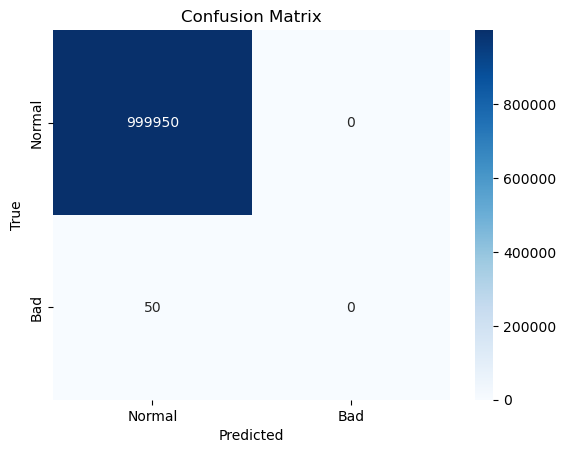

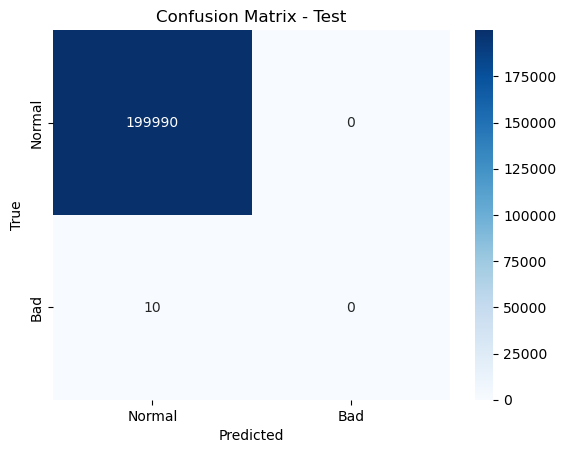

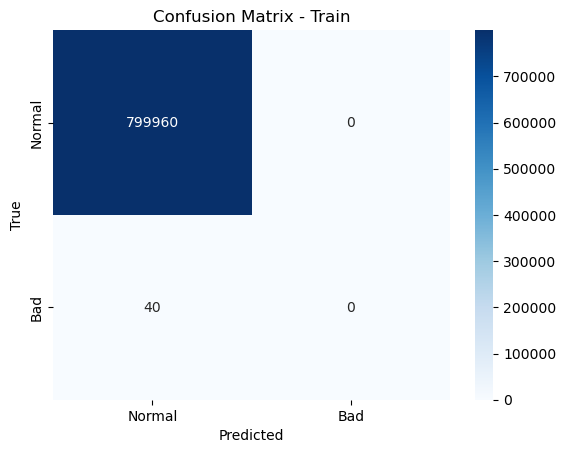

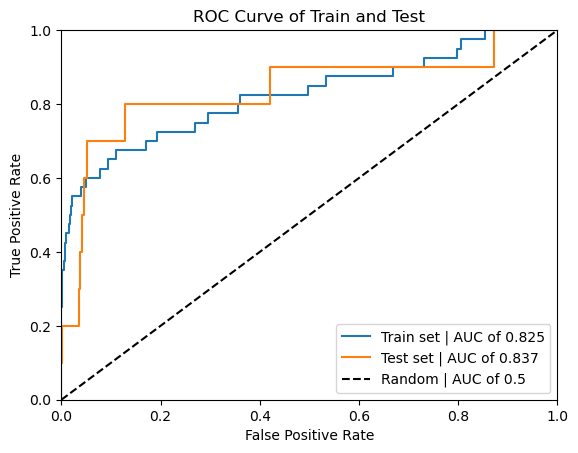

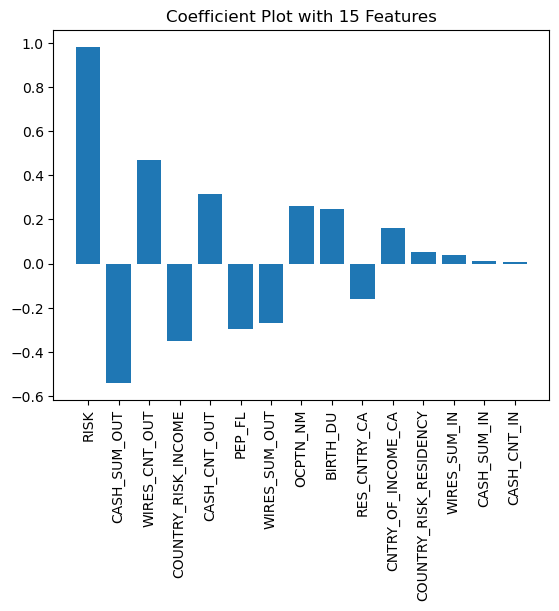

In [17]:
# Basic logistic regression approach
lr = LogisticRegression(random_state=7)

# Hide this warning: 
# Precision is ill-defined 
# and being set to 0.0 in labels with no predicted samples.
warnings.filterwarnings("ignore") 

# Train and test
lr = train_lr(X_train_norm, y_train, lr)
m1 = test_lr(X_test_norm, y_test, lr)

# Show confusion matrix
bad1, cm1 = show_confusion(lr, scaler, df, selected_features)

# Show train and test confusion matrix
plot_cm_roc(lr, X_train_norm, X_test_norm, y_train, y_test)

# Show coef of training set
plot_coefficient(lr, X_train) # need X_train's column names


Original actor distribution:
False    799960
True         40
Name: BAD_STATUS, dtype: int64
Average validation accuracy: 0.8585
Average validation precision: 0.9999
Average validation recall: 0.8585
Test accuracy: 0.8584
Test precision: 0.9999
Test recall: 0.8584


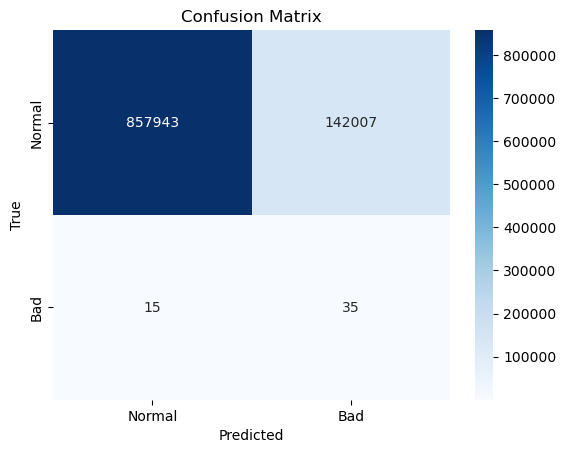

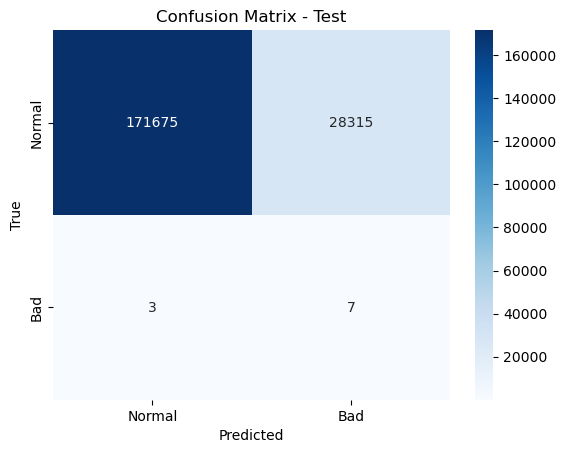

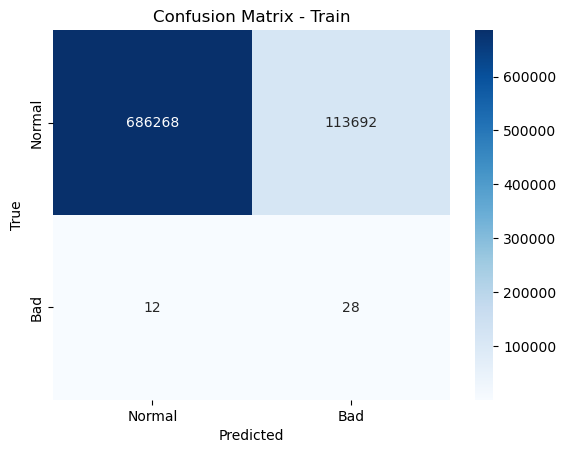

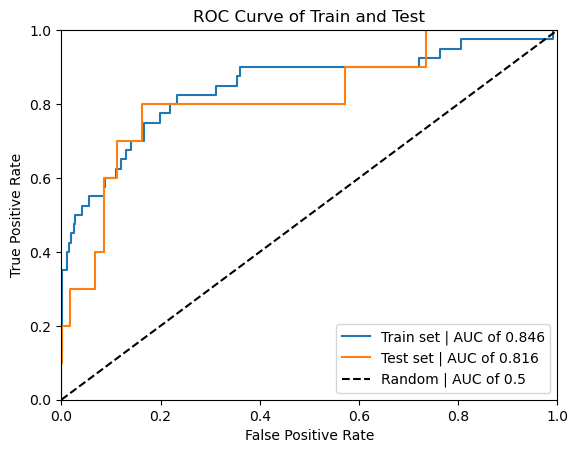

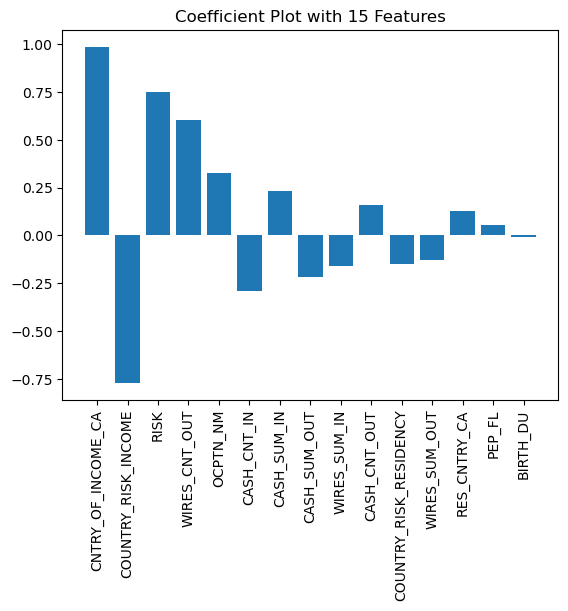

In [18]:
# Weighted sklearn hyperparameter approach
lr_sklearn = LogisticRegression(class_weight='balanced', random_state=7)

# Train and test
lr_sklearn  = train_lr(X_train_norm, y_train, lr_sklearn)
m2 = test_lr(X_test_norm, y_test, lr_sklearn)

# Show confusion matrix
bad2, cm2 = show_confusion(lr_sklearn, scaler, df, selected_features)

# Show train and test confusion matrix
plot_cm_roc(lr_sklearn, X_train_norm, X_test_norm, y_train, y_test)

# Show coef of training set
plot_coefficient(lr_sklearn, X_train) # need X_train's column names


SMOTE oversampling actor distribution:
False    799960
True     799960
Name: BAD_STATUS, dtype: int64
Average validation accuracy: 0.7884
Average validation precision: 0.7999
Average validation recall: 0.7884
Test accuracy: 0.8865
Test precision: 0.9999
Test recall: 0.8865


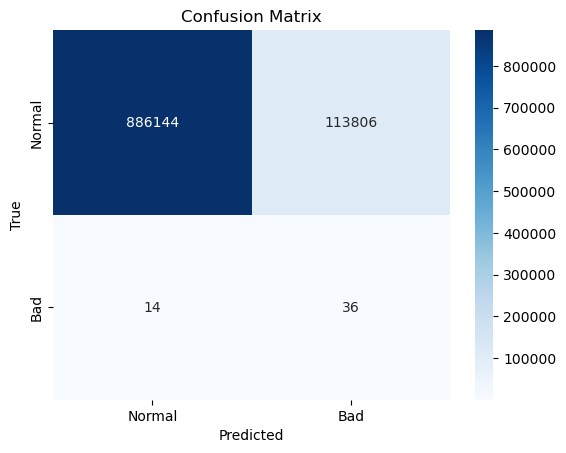

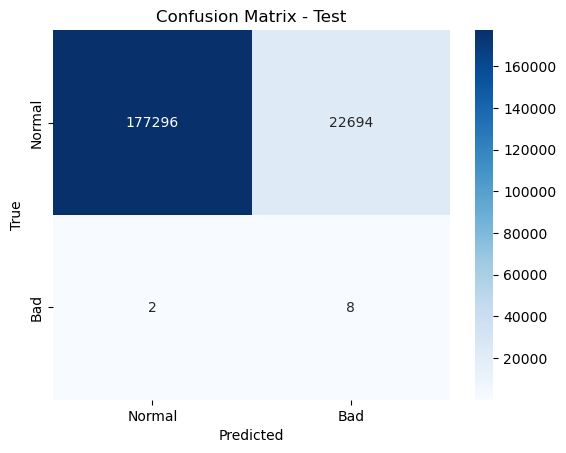

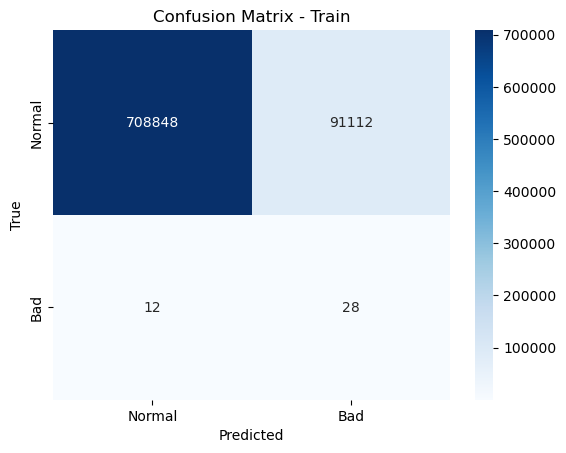

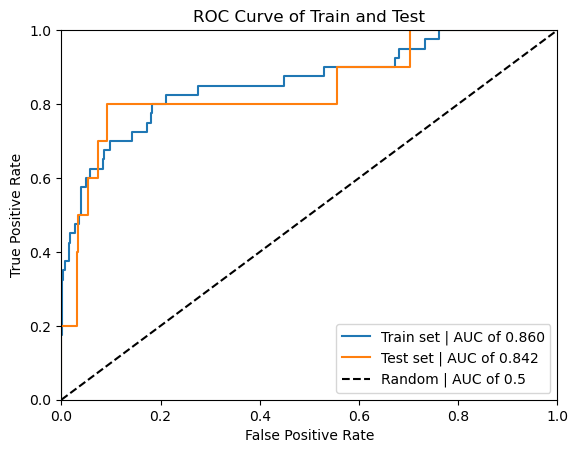

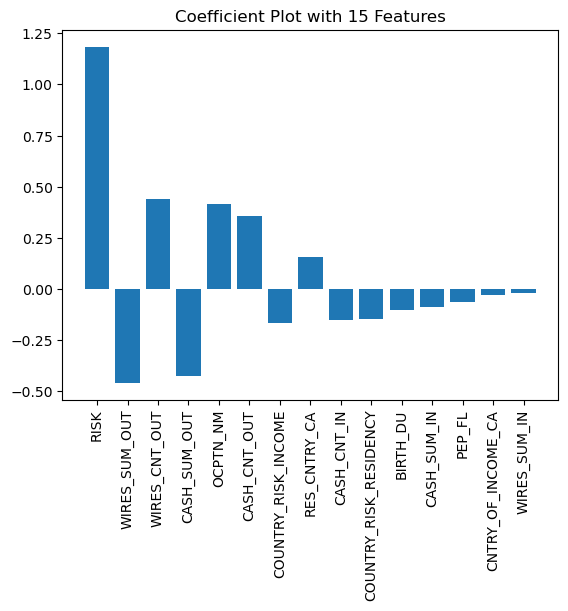

In [19]:
# SMOTE approach
lr_smote = LogisticRegression(random_state=7)

# Train and test
lr_smote = train_lr(X_train_norm, y_train, lr_smote, resample='SMOTE')
m3 = test_lr(X_test_norm, y_test, lr_smote)

# Show confusion matrix
bad3, cm3 = show_confusion(lr_smote, scaler, df, selected_features)

# Show train and test confusion matrix
plot_cm_roc(lr_smote, X_train_norm, X_test_norm, y_train, y_test)

# Show coef of training set
plot_coefficient(lr_smote, X_train) # need X_train's column names

Random oversampling actor distribution:
False    799960
True     799960
Name: BAD_STATUS, dtype: int64
Average validation accuracy: 0.7846
Average validation precision: 0.7931
Average validation recall: 0.7846
Test accuracy: 0.8699
Test precision: 0.9999
Test recall: 0.8699


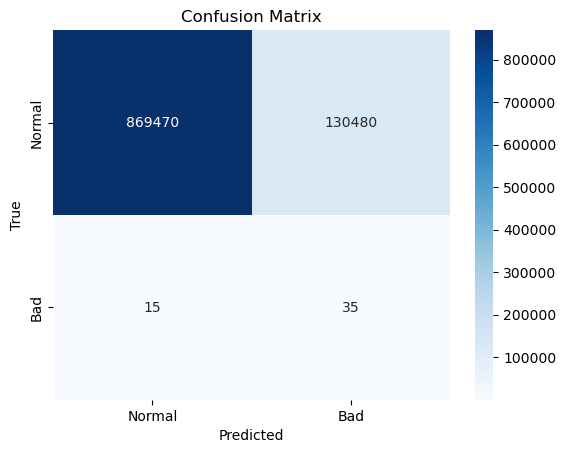

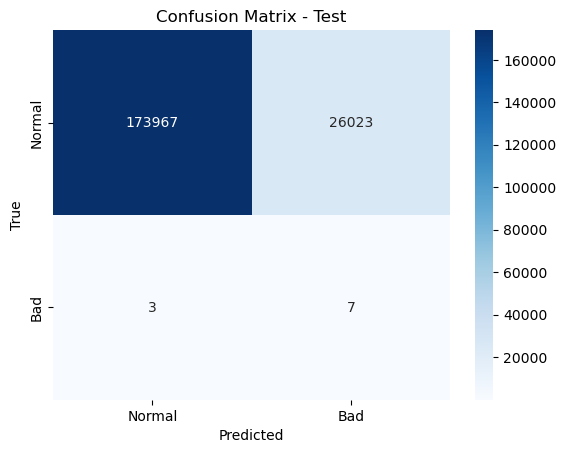

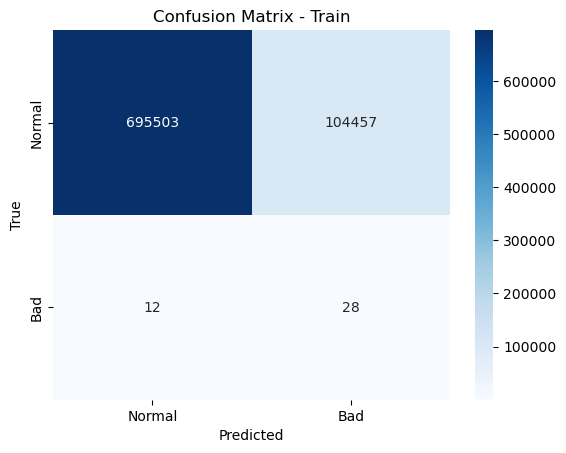

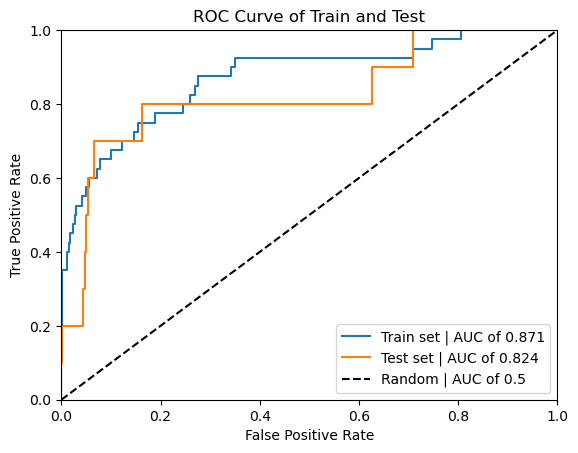

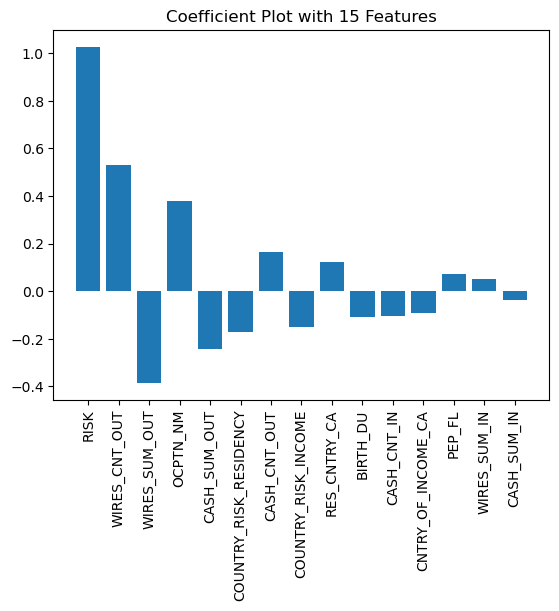

In [21]:
# ROS approach
lr_ros = LogisticRegression(random_state=7)

# Train and test
lr_ros = train_lr(X_train_norm, y_train, lr_ros, resample='ROS')
m4 = test_lr(X_test_norm, y_test, lr_ros)

# Show confusion matrix
bad4, cm4 = show_confusion(lr_ros, scaler, df, selected_features)

# Show train and test confusion matrix
plot_cm_roc(lr_ros, X_train_norm, X_test_norm, y_train, y_test)

# Show coef of training set
plot_coefficient(lr_ros, X_train) # need X_train's column names

## Random Forest and Decision Tree Modelling

In [28]:
# Training the tree model with resampling methods
def train_tr(X_train_norm:pd.DataFrame,
             y_train:pd.DataFrame,
             tree_model:DecisionTreeClassifier or RandomForestClassifier,
             iter:int = 10,
             rand_seed:int = 40,
             resample:str = None):
    
    # Check resample method input sanity
    if resample:
        assert resample=='ROS' or resample=='SMOTE',\
            f"resample can only be 'ROS' or 'SMOTE'"
    
    # Initialize an empty list to store the accuracy scores
    acc_scores = []
    prec_scores = []
    rec_scores = []

    # Apply different resampling method to enlarge the bad actor sample size
    if resample == 'ROS': # Random Oversampling
        ros = RandomOverSampler(random_state=rand_seed)
        X_train_norm, y_train = ros.fit_resample(X_train_norm, y_train)
        print("Random oversampling actor distribution:")
        print(pd.Series(y_train).value_counts())
    elif resample == 'SMOTE': # Synthetic Minority Oversampling Technique
        smote = SMOTE(random_state=rand_seed)
        X_train_norm, y_train = smote.fit_resample(X_train_norm, y_train)
        print("SMOTE oversampling actor distribution:")
        print(pd.Series(y_train).value_counts())
    else: # No resampling
        print("Original actor distribution:")
        print(pd.Series(y_train).value_counts())
 
    for i in range(iter):
        # Split into training and validating sets
        X_ttrain, X_valid, y_ttrain, y_valid =\
            train_test_split(X_train_norm, y_train, stratify=y_train,
                              test_size=.2, random_state=rand_seed+i)
        
        # Train with the normalized training data
        tree_model.fit(X_ttrain, y_ttrain)
        
        # Evaluate the normalized validating data
        y_pred = tree_model.predict(X_valid)
        accuracy = accuracy_score(y_valid, y_pred)
        precison = precision_score(y_valid, y_pred, average='weighted')
        recall = recall_score(y_valid, y_pred, average='weighted')

        # Add validation results to lists
        acc_scores.append(accuracy)
        prec_scores.append(precison)
        rec_scores.append(recall)

    # Show final result
    print('Average validation accuracy:', round(np.mean(acc_scores), 4))
    print('Average validation precision:', round(np.mean(prec_scores), 4))
    print('Average validation recall:', round(np.mean(rec_scores), 4))

    # Return model results
    return tree_model


# Testing the logistic regression model with the test set
def test_tr(X_test:pd.DataFrame,
            y_test:pd.DataFrame,
            tr_model:DecisionTreeClassifier or RandomForestClassifier,
            weighted:bool = True):
    
    # Generate test metrics
    y_test_pred = tr_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)

    # Whether use weighted method to display metric result
    if weighted:
        precison = precision_score(y_test, y_test_pred, average='weighted')
        recall = recall_score(y_test, y_test_pred, average='weighted')
    else: # Not able to see the actual result
        precison = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)

    # Show final result
    print('Test accuracy:', round(accuracy, 4))
    print('Test precision:', round(precison, 4))
    print('Test recall:', round(recall, 4))
    return (accuracy, precison, recall)

## RFs and DTs Perfromance Analysis

Original actor distribution:
False    799960
True         40
Name: BAD_STATUS, dtype: int64
Average validation accuracy: 0.9999
Average validation precision: 0.9999
Average validation recall: 0.9999
Test accuracy: 0.9999
Test precision: 0.9999
Test recall: 0.9999


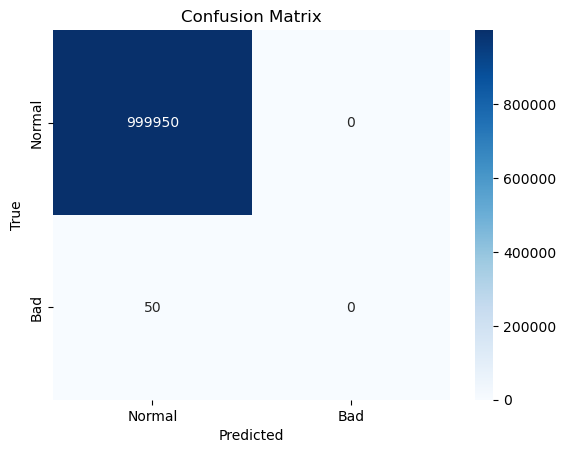

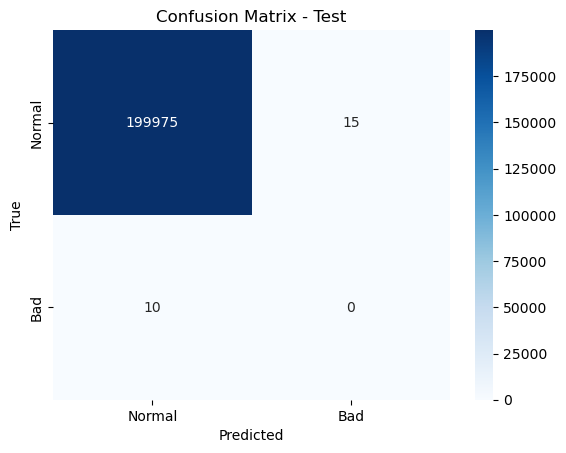

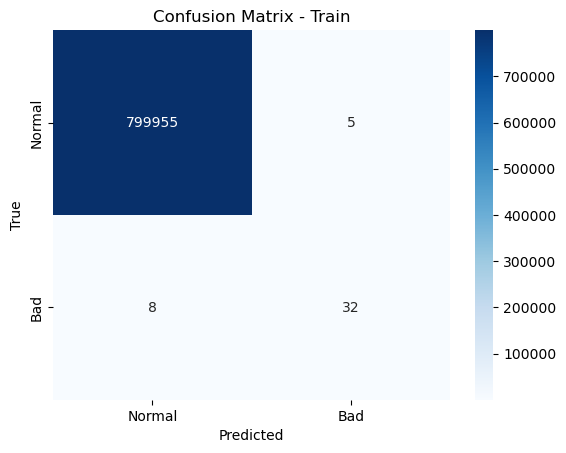

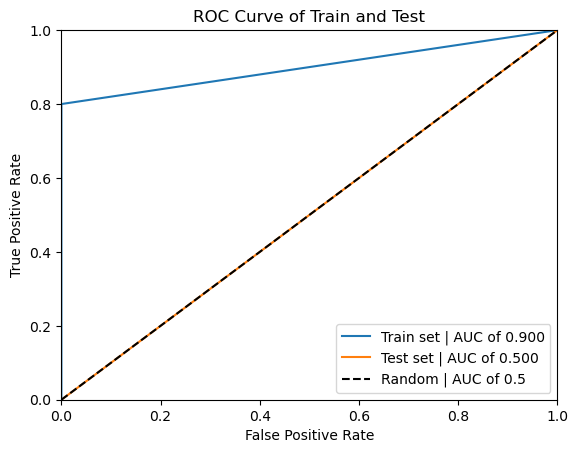

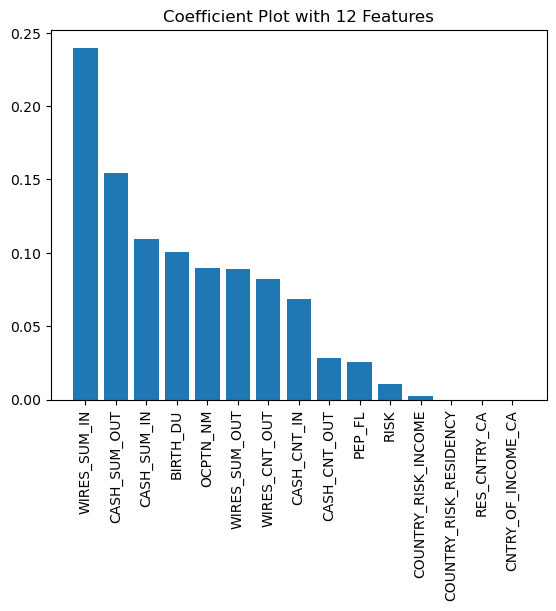

In [23]:
# Basic decision tree approach
dt = DecisionTreeClassifier(random_state=7)

# Train and test
dt = train_tr(X_train, y_train, dt)
m1 = test_tr(X_test, y_test, dt)

# Show confusion matrix
bad1, cm1 = show_confusion(dt, scaler, df, selected_features)

# Show train and test confusion matrix
plot_cm_roc(dt, X_train, X_test, y_train, y_test)

# Show coef of training set
plot_coefficient(dt, X_train) # need X_train's column names


Original actor distribution:
False    799960
True         40
Name: BAD_STATUS, dtype: int64
Average validation accuracy: 0.9999
Average validation precision: 0.9999
Average validation recall: 0.9999
Test accuracy: 0.9999
Test precision: 0.9999
Test recall: 0.9999


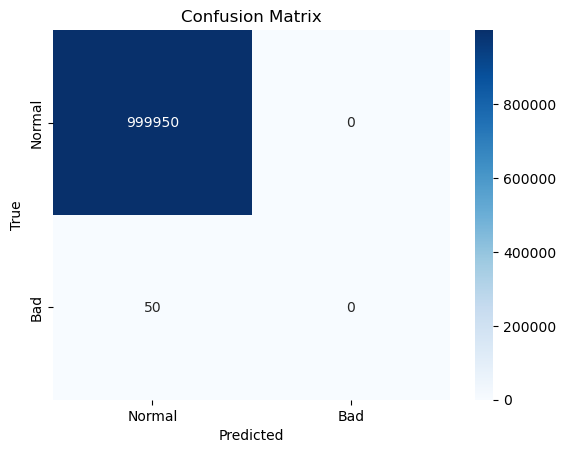

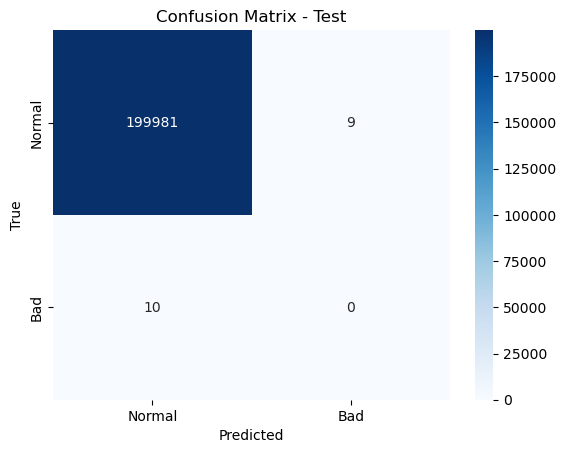

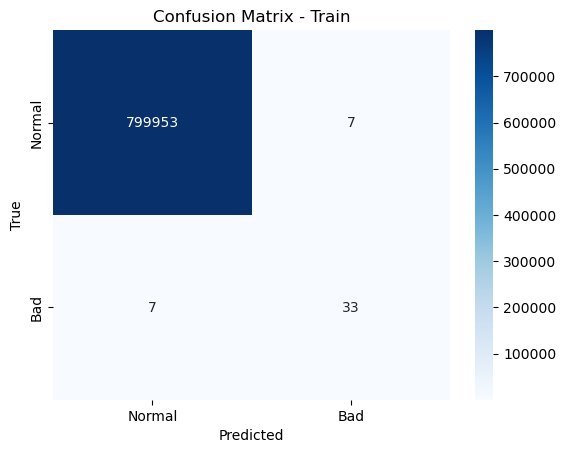

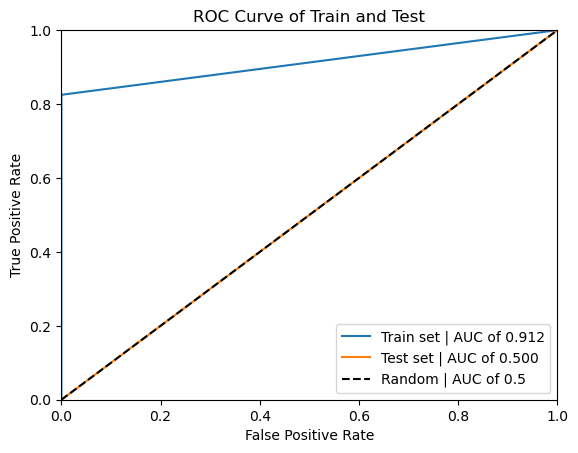

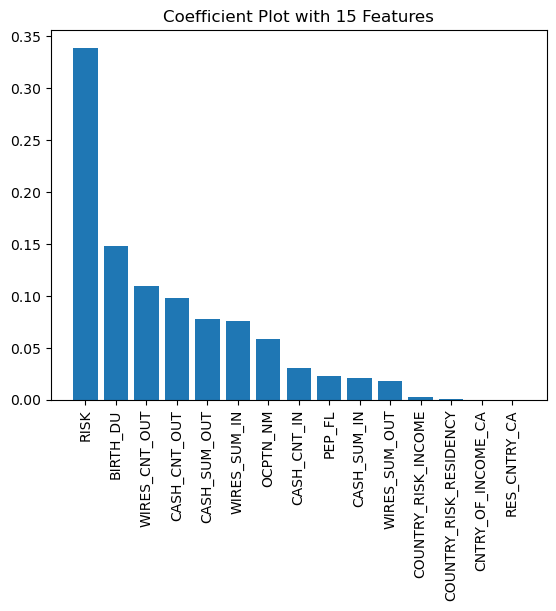

In [24]:
# Weighted sklearn hyperparameter approach
dt_sklearn = DecisionTreeClassifier(random_state=7, class_weight='balanced')

# Train and test
dt_sklearn = train_tr(X_train, y_train, dt_sklearn)
m2 = test_tr(X_test, y_test, dt_sklearn)

# Show confusion matrix
bad2, cm2 = show_confusion(dt_sklearn, scaler, df, selected_features)

# Show train and test confusion matrix
plot_cm_roc(dt_sklearn, X_train, X_test, y_train, y_test)

# Show coef of training set
plot_coefficient(dt_sklearn, X_train) # need X_train's column names


Original actor distribution:
False    799960
True         40
Name: BAD_STATUS, dtype: int64
Average validation accuracy: 1.0
Average validation precision: 0.9999
Average validation recall: 1.0
Test accuracy: 1.0
Test precision: 0.9999
Test recall: 1.0


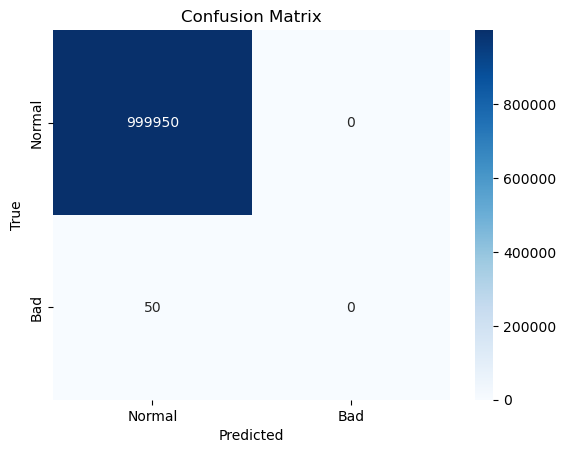

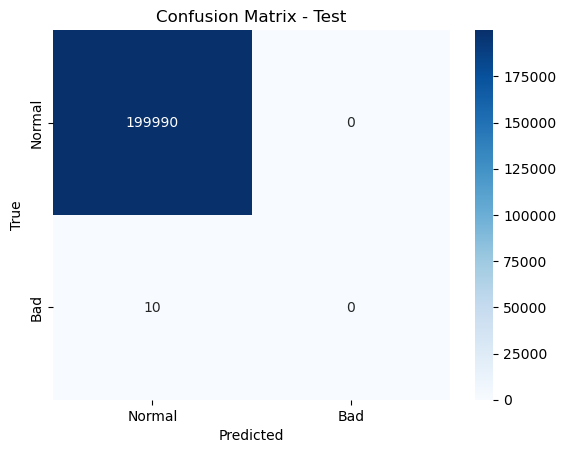

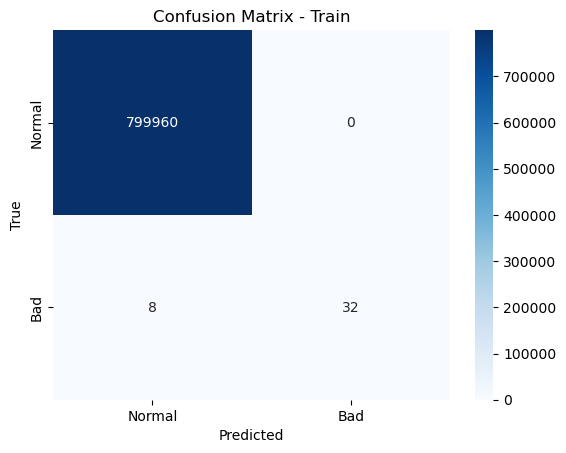

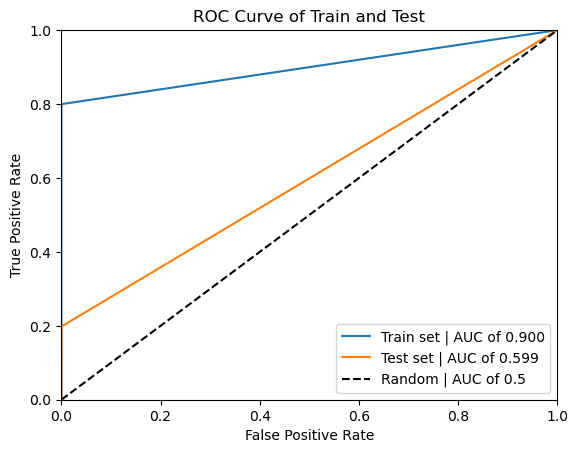

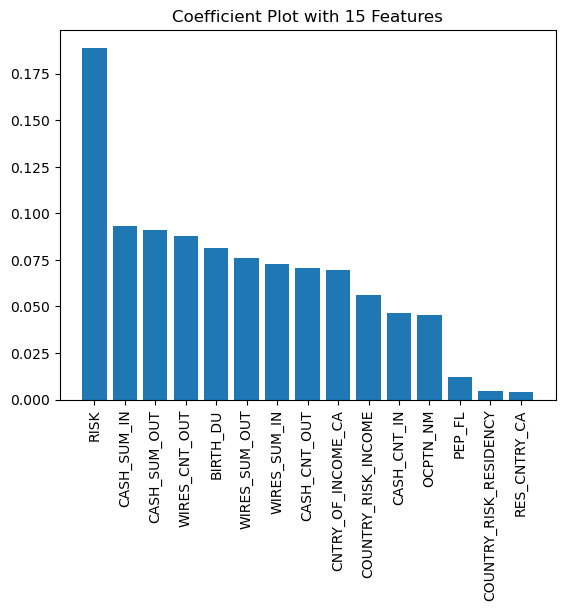

In [26]:
# Weighted sklearn hyperparameter approach
rf_sklearn = RandomForestClassifier(random_state=7, class_weight='balanced')

# Train and test
rf_sklearn = train_tr(X_train, y_train, rf_sklearn, iter=1)
m3 = test_tr(X_test, y_test, rf_sklearn)

# Show confusion matrix
bad3, cm3 = show_confusion(rf_sklearn, scaler, df, selected_features)

# Show train and test confusion matrix
plot_cm_roc(rf_sklearn, X_train, X_test, y_train, y_test)

# Show coef of training set
plot_coefficient(rf_sklearn, X_train) # need X_train's column names


SMOTE oversampling actor distribution:
False    799960
True     799960
Name: BAD_STATUS, dtype: int64
Average validation accuracy: 0.9999
Average validation precision: 0.9999
Average validation recall: 0.9999
Test accuracy: 0.9999
Test precision: 0.9999
Test recall: 0.9999


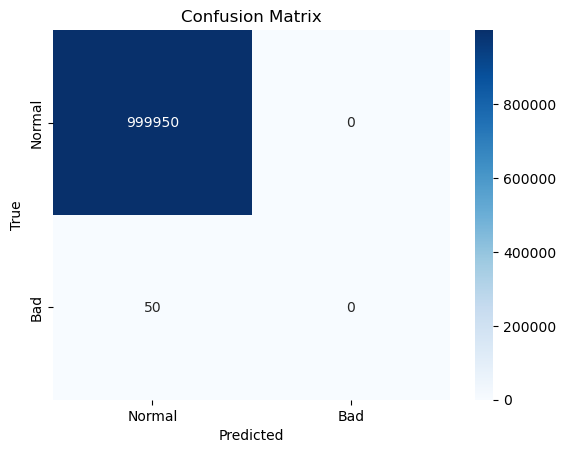

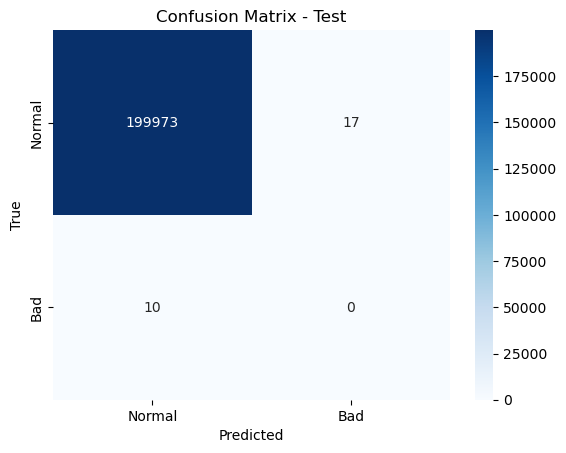

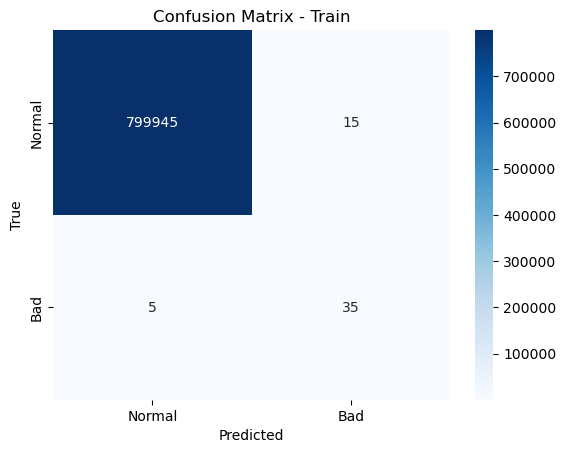

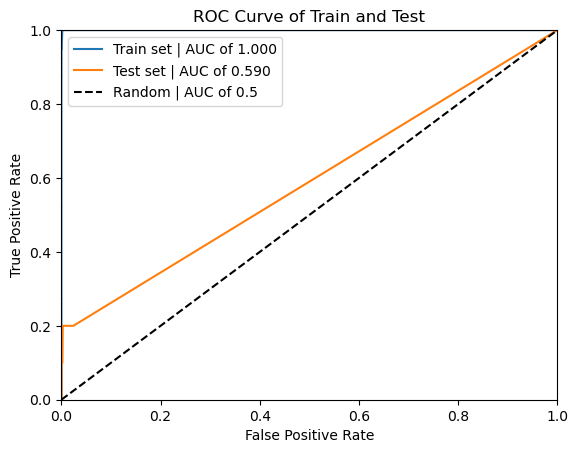

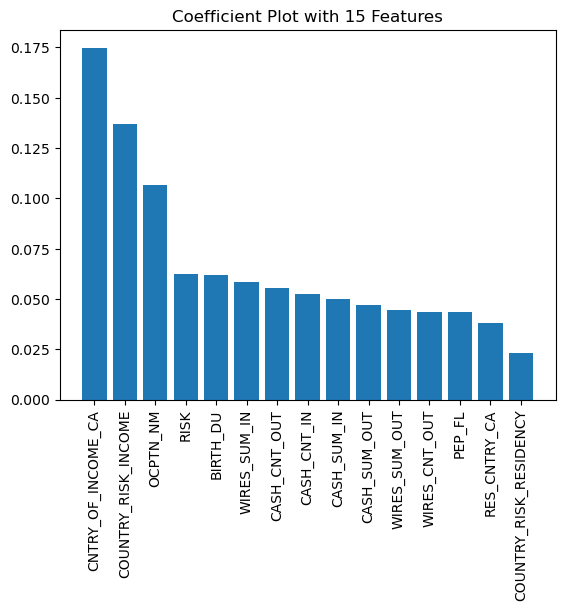

In [29]:
# Weighted sklearn hyperparameter approach
rf_smote = RandomForestClassifier(random_state=7)

# Train and test
rf_smote = train_tr(X_train, y_train, rf_smote, iter=1, resample='SMOTE')
m4 = test_tr(X_test, y_test, rf_smote)

# Show confusion matrix
bad4, cm4 = show_confusion(rf_smote, scaler, df, selected_features)

# Show train and test confusion matrix
plot_cm_roc(rf_smote, X_train, X_test, y_train, y_test)

# Show coef of training set
plot_coefficient(rf_smote, X_train) # need X_train's column names
